In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_context('poster')

In [5]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [8]:
df = pd.read_pickle('CCPA.pkl.gz')

In [9]:
dfc = df.loc[(df.experiment.isin(['e1','e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [10]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

In [11]:
d = cp.generate_decline(dfc, scale=False)

In [12]:
def convert_func(df, x_col='day', value_col='FL', rolling_period='3d', resample_period='1d' ):
    t = df
    t.index = pd.to_timedelta(t[x_col], unit='d')
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'median'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')


In [13]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
t0  = d.groupby(groupby_cols).get_group(('e3, 10A','e3','10A', 'C9B', 'DE', 'Co_Culture'))

In [14]:
def convert_func(t0, x_col='day', value_col='FL', rolling_period='3d', resample_period='1d' ):
    # x_col='day'
    # rolling_period='3d'
    # resample_period='1d'
    # value_col='FL'
    t = t0
    t.index = pd.to_timedelta(t[x_col], unit='d')
    #t.sort_index(ascending=True, inplace=True)
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'mean'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t2.index= t2.index.astype('timedelta64[D]')
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')
    return t3


In [15]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
ds  = d.groupby(groupby_cols).apply(convert_func).reset_index() 

In [16]:
# ds.day = ds.day.astype('timedelta64[D]')
ds = ds[ds.day < 80]

In [17]:
ds.head()

experiment_sample experiment sample  PRO ALT     culture  day        FL
0           e1, 10A         e1    10A  C9B  DE  Co_Culture    0  5.227000
1           e1, 10A         e1    10A  C9B  DE  Co_Culture    1  4.138333
2           e1, 10A         e1    10A  C9B  DE  Co_Culture    2  3.704389
3           e1, 10A         e1    10A  C9B  DE  Co_Culture    3  3.270444
4           e1, 10A         e1    10A  C9B  DE  Co_Culture    4  2.836500

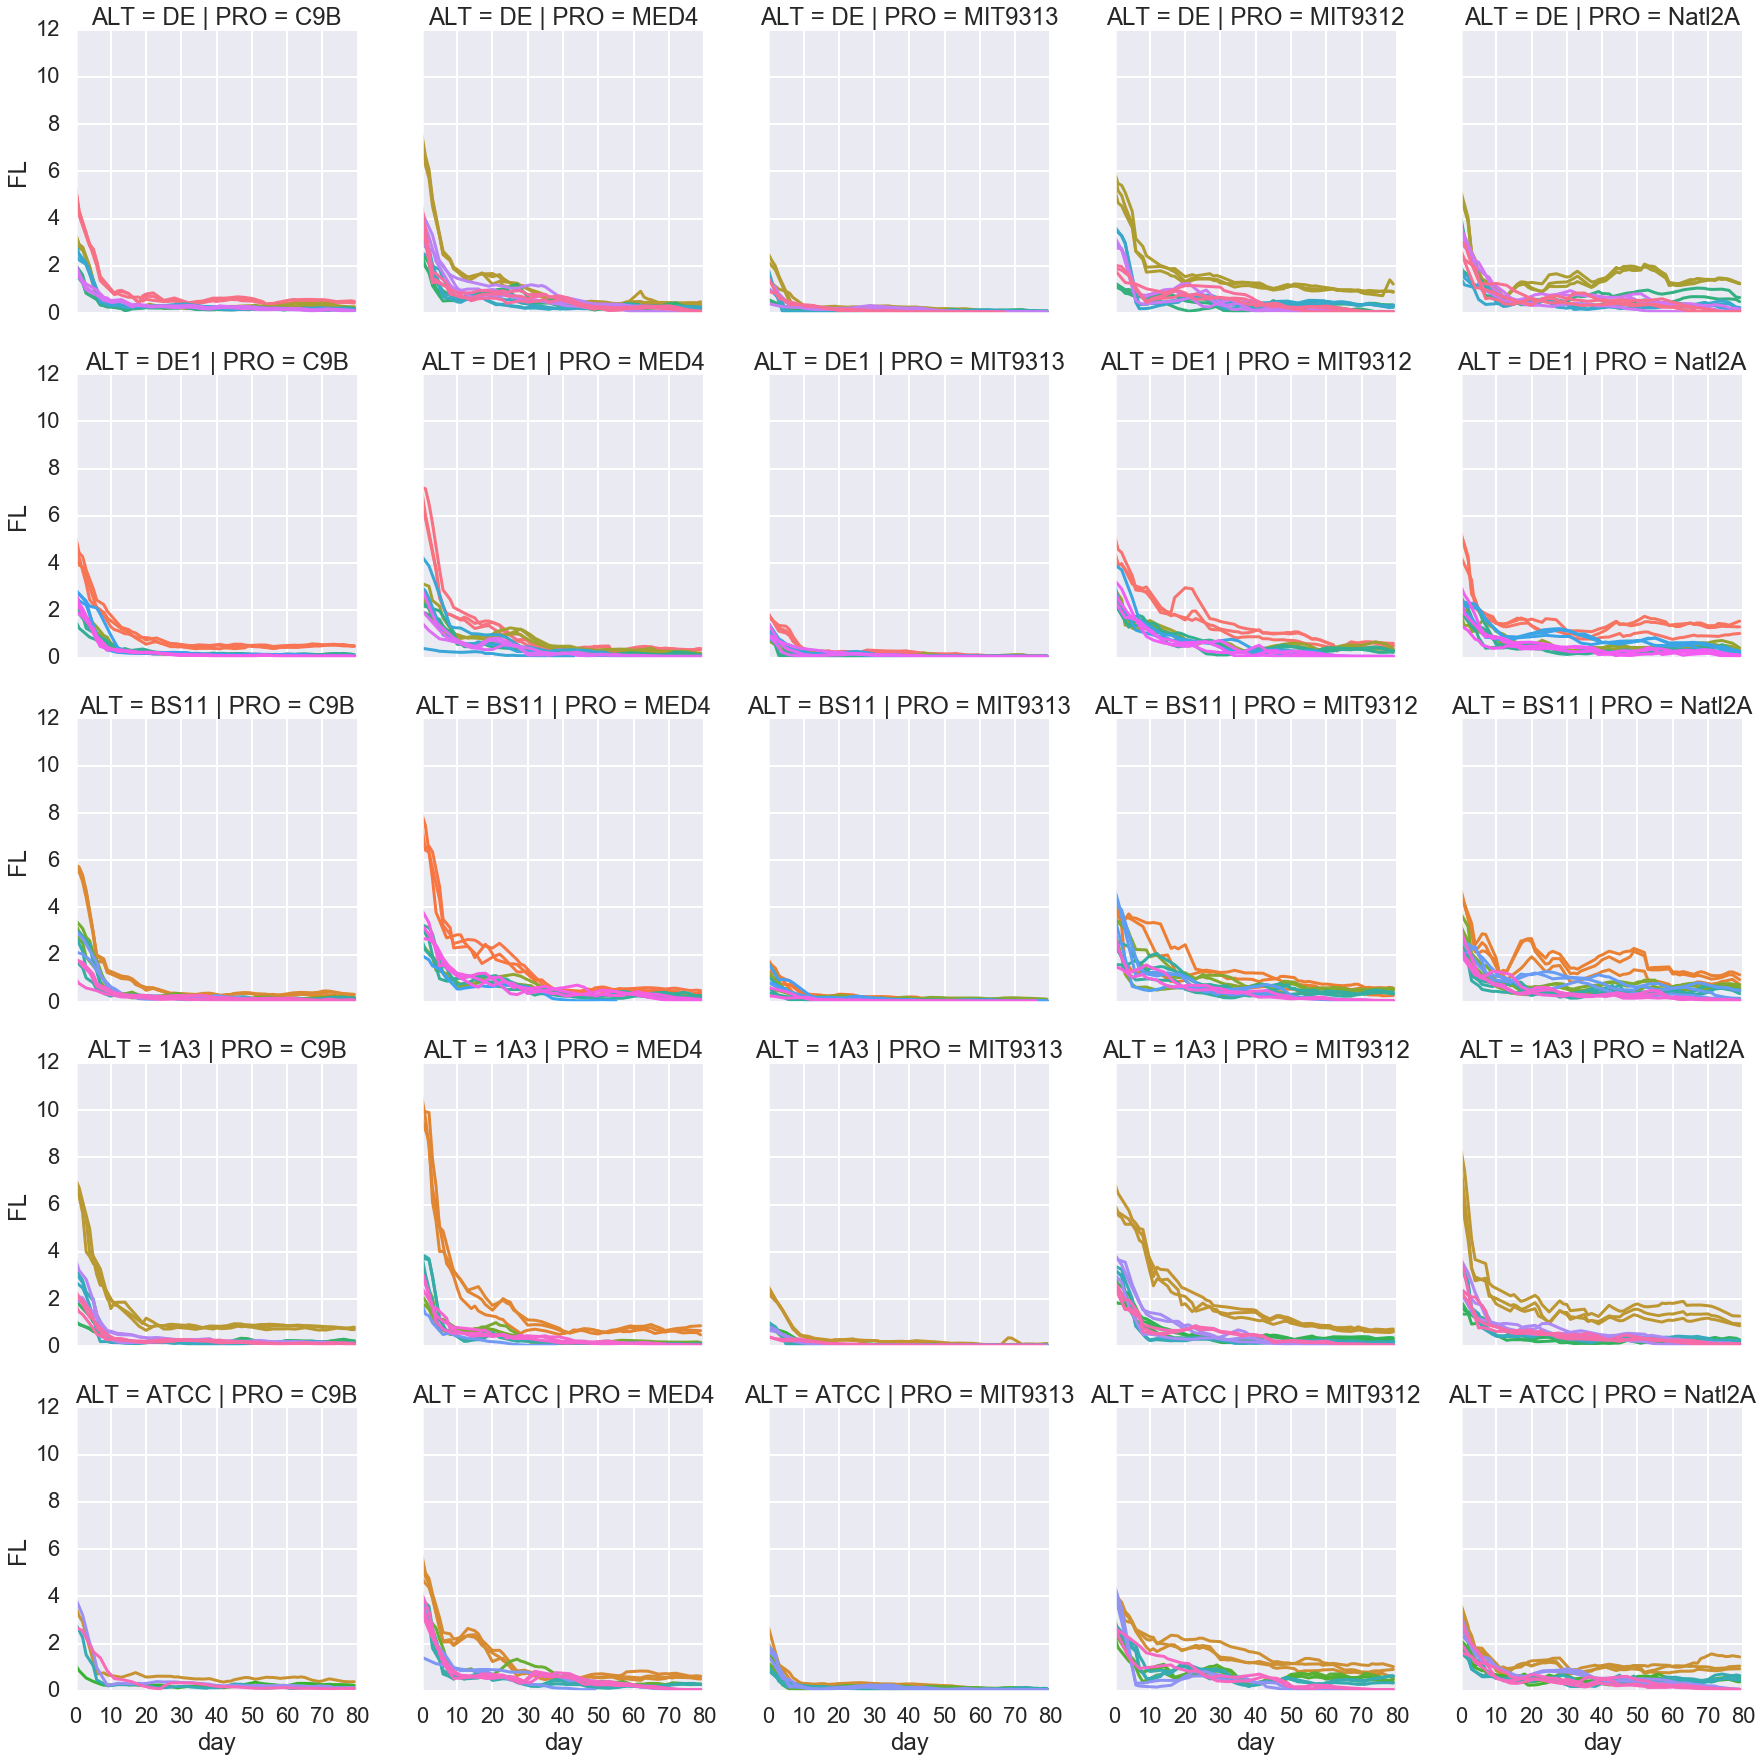

In [18]:
sns.relplot(data=ds, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            x='day', y='FL', kind='line', hue='experiment_sample', legend=False)

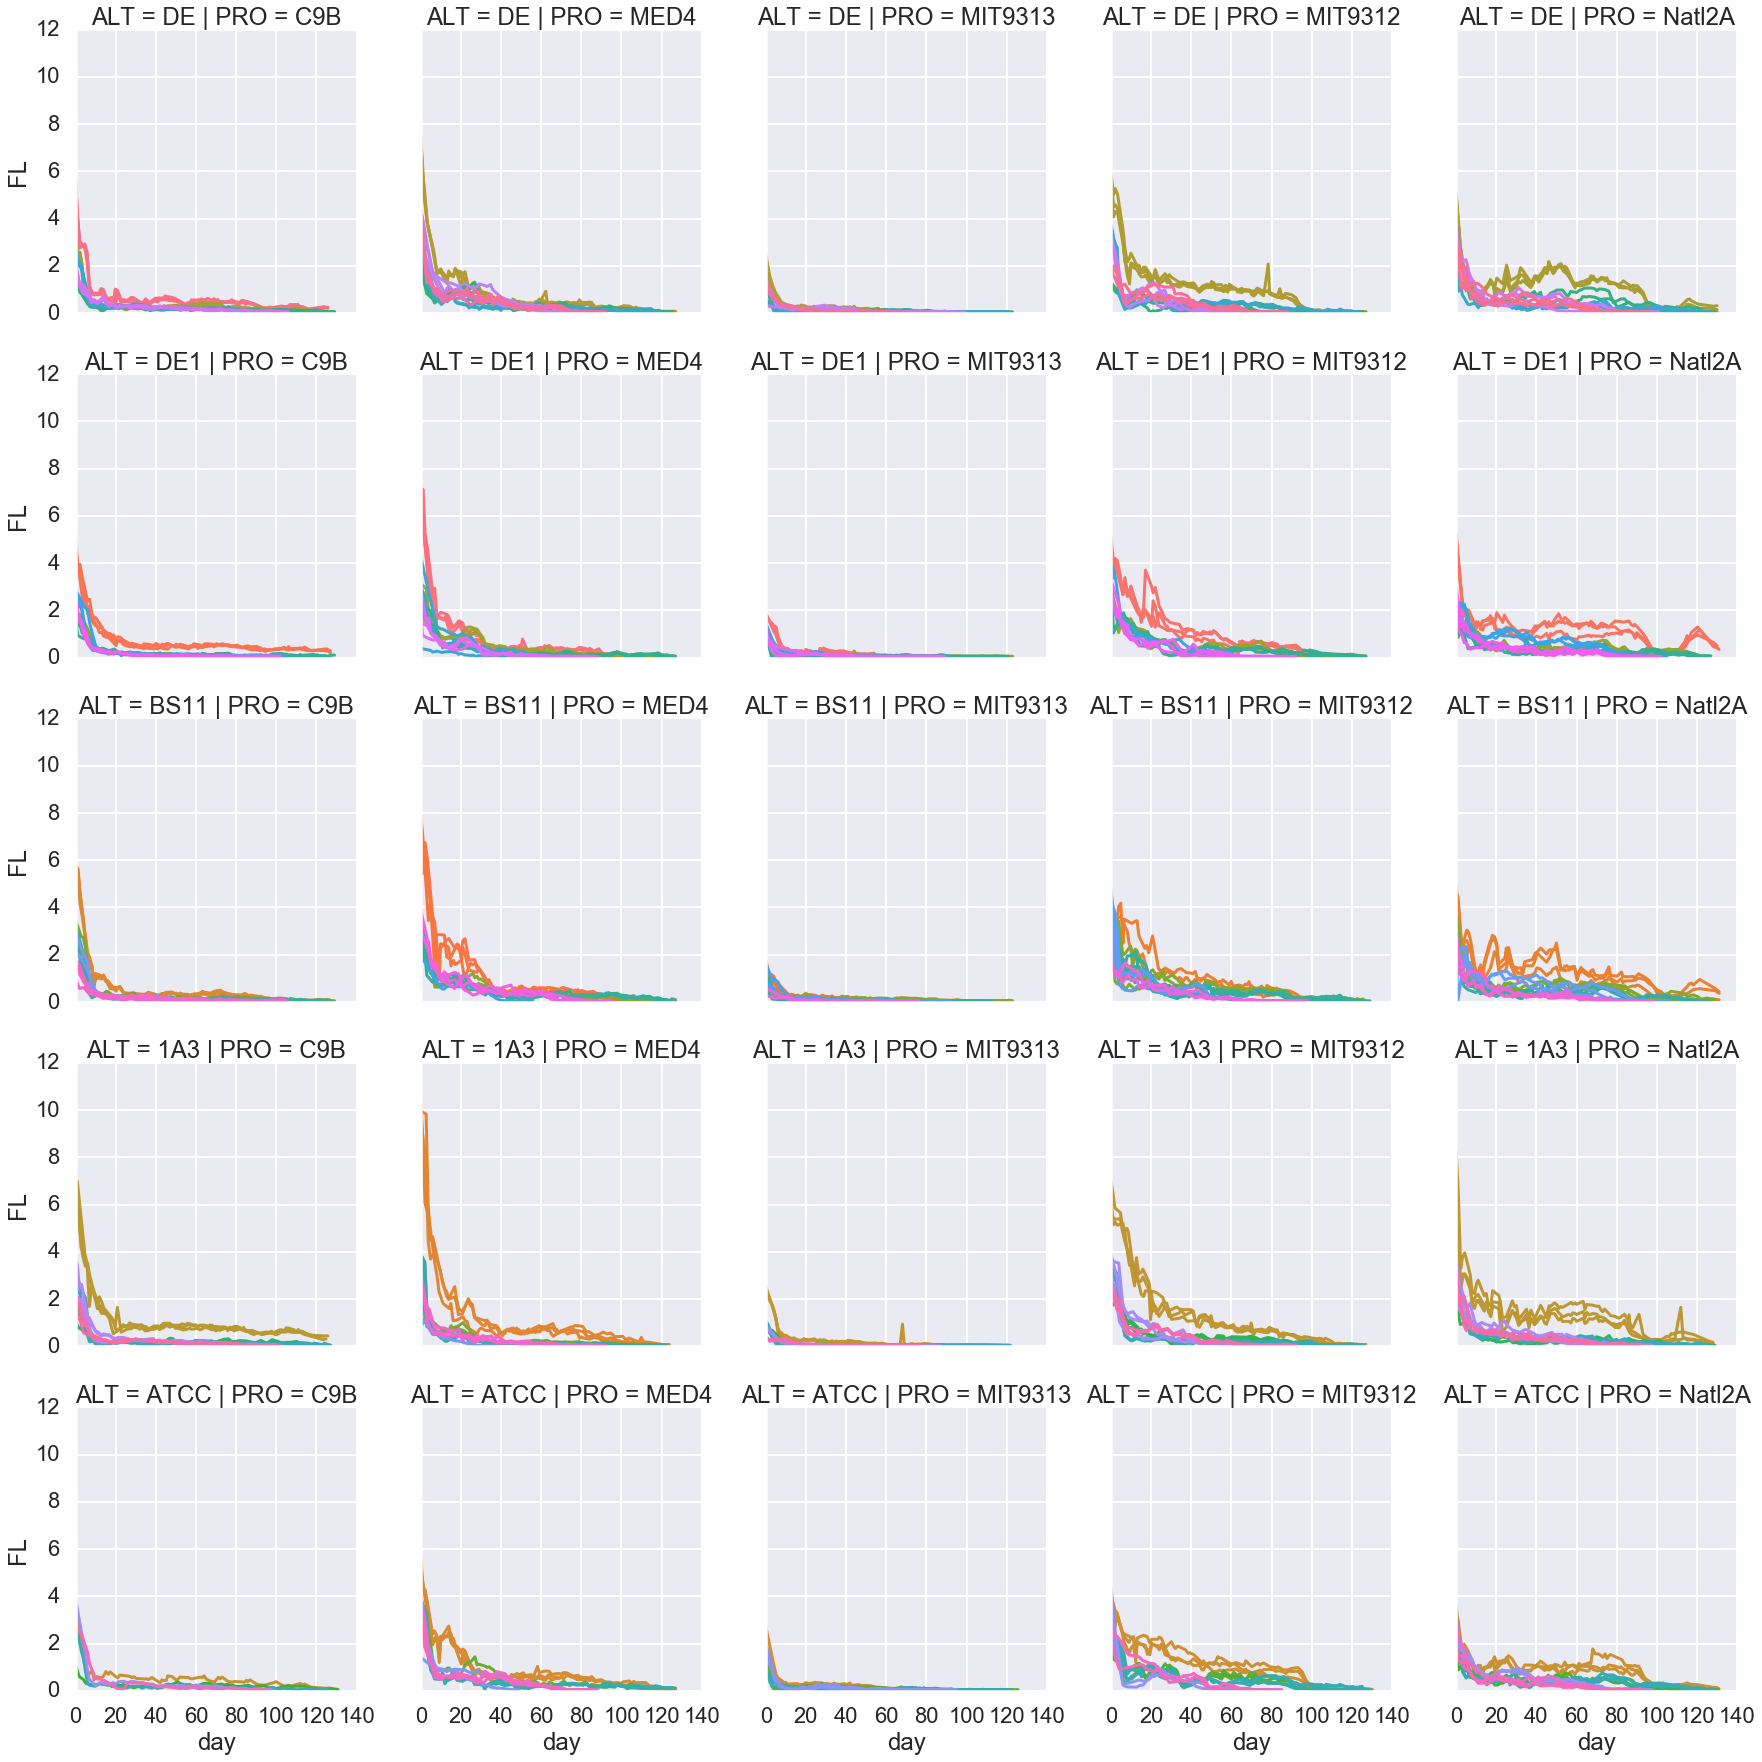

In [19]:
sns.relplot(data=d, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            x='day', y='FL', kind='line', hue='experiment_sample', legend=False)

In [20]:
ds['decline'] = ds['FL']

In [21]:
n = 'exponential'
f = cp.model_exponential
dfe = ds.loc[:, ['day', 'experiment_sample', 'experiment', 'PRO', 'ALT', 'sample', 'culture', 'FL']]
t = dfe.groupby('experiment_sample').apply(lambda x: cp.apply_fit(x, f))
dfe[n] = t['y_pred']
for i in range(3):
    dfe[f'popt_{i}'] = t[f'popt_{i}']
dfe['decline'] = dfe.FL
dfe['exponential_diff'] = dfe.FL - dfe.exponential
#dfe['decline_scaled'] = dfe.groupby('experiment_sample').FL.transform(lambda x: x / x.max())
#df_exp_coef = dfe.groupby(['experiment_sample','popt_0', 'popt_1', 'popt_2'])['decline'].count().reset_index(level=[1,2,3])\
#.drop(columns='decline')

[4.74496026 0.19144331 0.47531817 1.        ]
[4.74496026 0.19144331 0.47531817 1.        ]
[4.79108319 0.19685435 0.55428247 1.        ]
[4.91869646 0.20926067 0.47826418 1.        ]
[6.86601709 0.11673889 0.3751573  1.        ]
[6.22550146 0.14003509 0.36625397 1.        ]
[6.07876645 0.12425873 0.39686549 1.        ]
[1.74007499 0.16194527 0.13056622 1.        ]
[1.79870478 0.16804642 0.12747251 1.        ]
[1.74762282 0.14225616 0.13224771 1.        ]
[3.54650087 0.05767721 0.62227148 1.        ]
[3.94843065 0.03890449 0.33159094 1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[3.82723877 0.0563795  0.40200705 1.        ]
[3.37784876 0.18321448 0.9429781  1.        ]
[3.96043816 0.31725917 1.38736806 1.        ]
[3.90922433 0.31705784 1.37105032 1.        ]
[4.07750312 0.14769651 0.49729013 1.        ]
[4.66702967 0.13076666 0.49814839 1.        ]
[4.07823966 0.13114804 0.42753529 1.        ]
Optimal parameters not found: The maximu

[3.69536334 0.27260279 0.1643623  1.        ]
[4.58825122 0.26936497 0.14898259 1.        ]
[4.72056549 0.27437429 0.16821171 1.        ]
[1.67810397 0.19600662 0.1368953  1.        ]
[2.78748831 0.23473951 0.1301987  1.        ]
[3.49354047 0.20296664 0.14063303 1.        ]
[4.17921362 0.21402512 0.28189777 1.        ]
[3.82273081 0.24764315 0.28126717 1.        ]
[3.47843018 0.23626225 0.2484419  1.        ]
[0.76597398 0.19342497 0.07211789 1.        ]
[0.78296405 0.1526027  0.06774895 1.        ]
[0.98739403 0.34018843 0.08224457 1.        ]
[2.43028361 0.1310805  0.44771549 1.        ]
[2.26732093 0.08634662 0.31003054 1.        ]
[2.46485672 0.12367303 0.45634532 1.        ]
[1.66762549 0.18625085 0.43208616 1.        ]
[1.22860758 0.21999781 0.39932544 1.        ]
[1.55930921 0.30931649 0.45779641 1.        ]
[3.05968718 0.2706172  0.14874979 1.        ]
[1.12642246 0.32595667 0.04752765 1.        ]
[1.11184007 0.3211223  0.04986211 1.        ]
[3.76440597 0.25561339 0.19071165 

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


In [22]:

dfe.head()

day experiment_sample experiment  PRO ALT sample     culture        FL  \
0    0           e1, 10A         e1  C9B  DE    10A  Co_Culture  5.227000   
1    1           e1, 10A         e1  C9B  DE    10A  Co_Culture  4.138333   
2    2           e1, 10A         e1  C9B  DE    10A  Co_Culture  3.704389   
3    3           e1, 10A         e1  C9B  DE    10A  Co_Culture  3.270444   
4    4           e1, 10A         e1  C9B  DE    10A  Co_Culture  2.836500   

   exponential   popt_0    popt_1    popt_2   decline  exponential_diff  
0     5.220278  4.74496  0.191443  0.475318  5.227000          0.006722  
1     4.393547  4.74496  0.191443  0.475318  4.138333         -0.255214  
2     3.710860  4.74496  0.191443  0.475318  3.704389         -0.006471  
3     3.147120  4.74496  0.191443  0.475318  3.270444          0.123324  
4     2.681603  4.74496  0.191443  0.475318  2.836500          0.154897

In [23]:
dfe['diff_norm'] = dfe.groupby('experiment_sample')['exponential_diff'].transform(lambda x: (x - x.mean()) / x.std() )

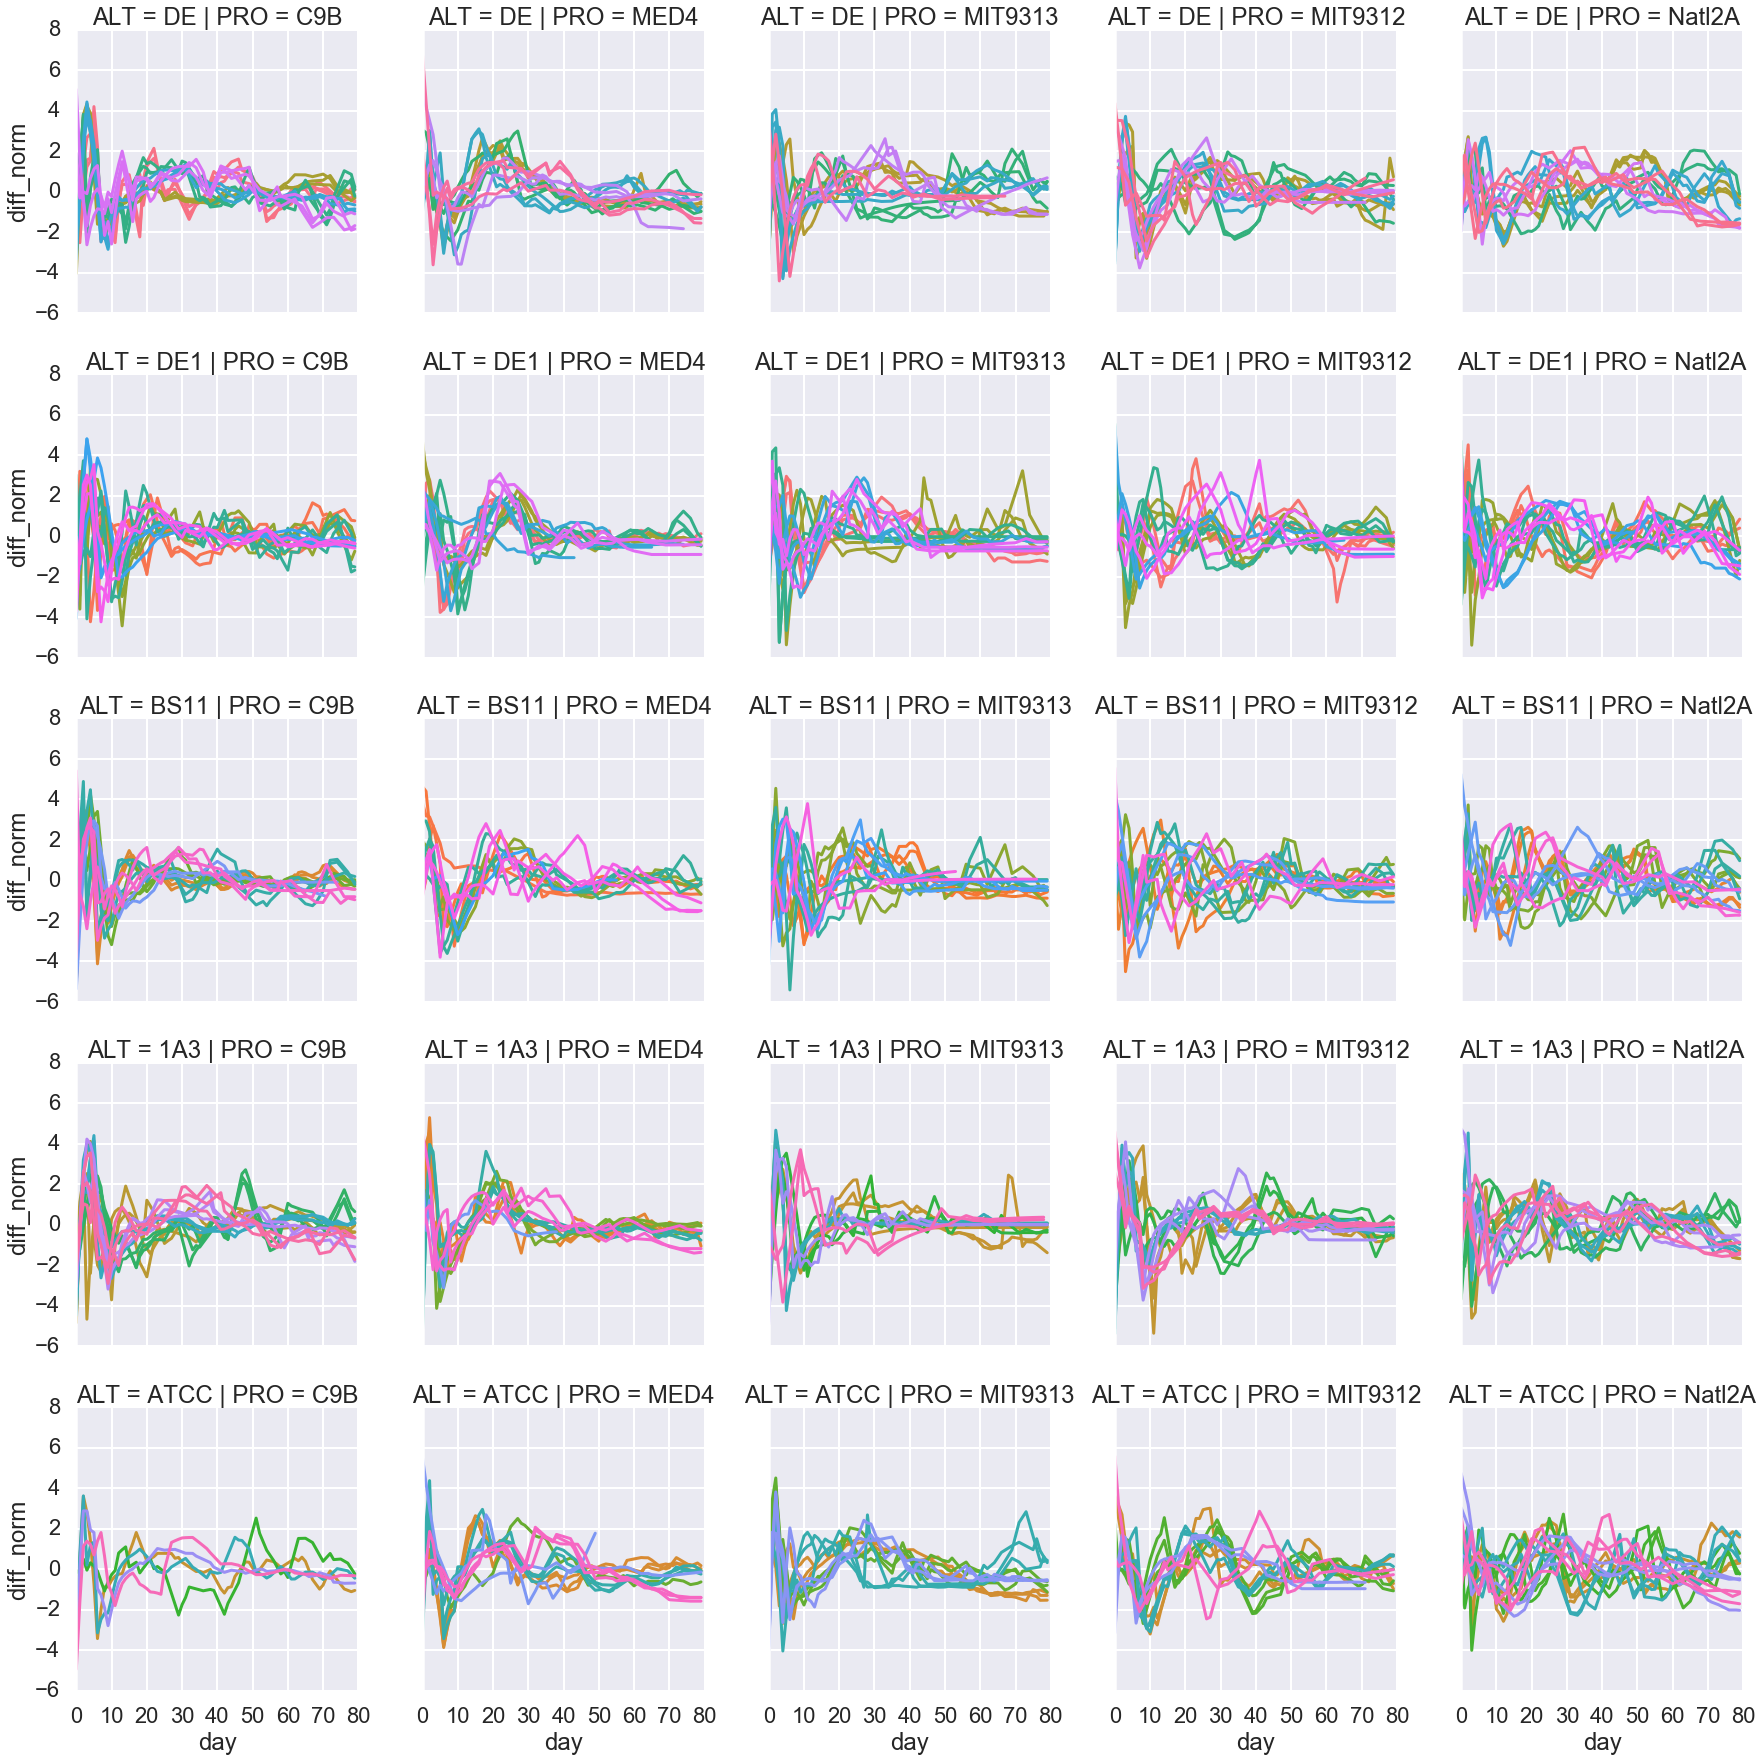

In [24]:
sns.relplot(data=dfe, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            x='day', y='diff_norm', kind='line', hue='experiment_sample', legend=False)

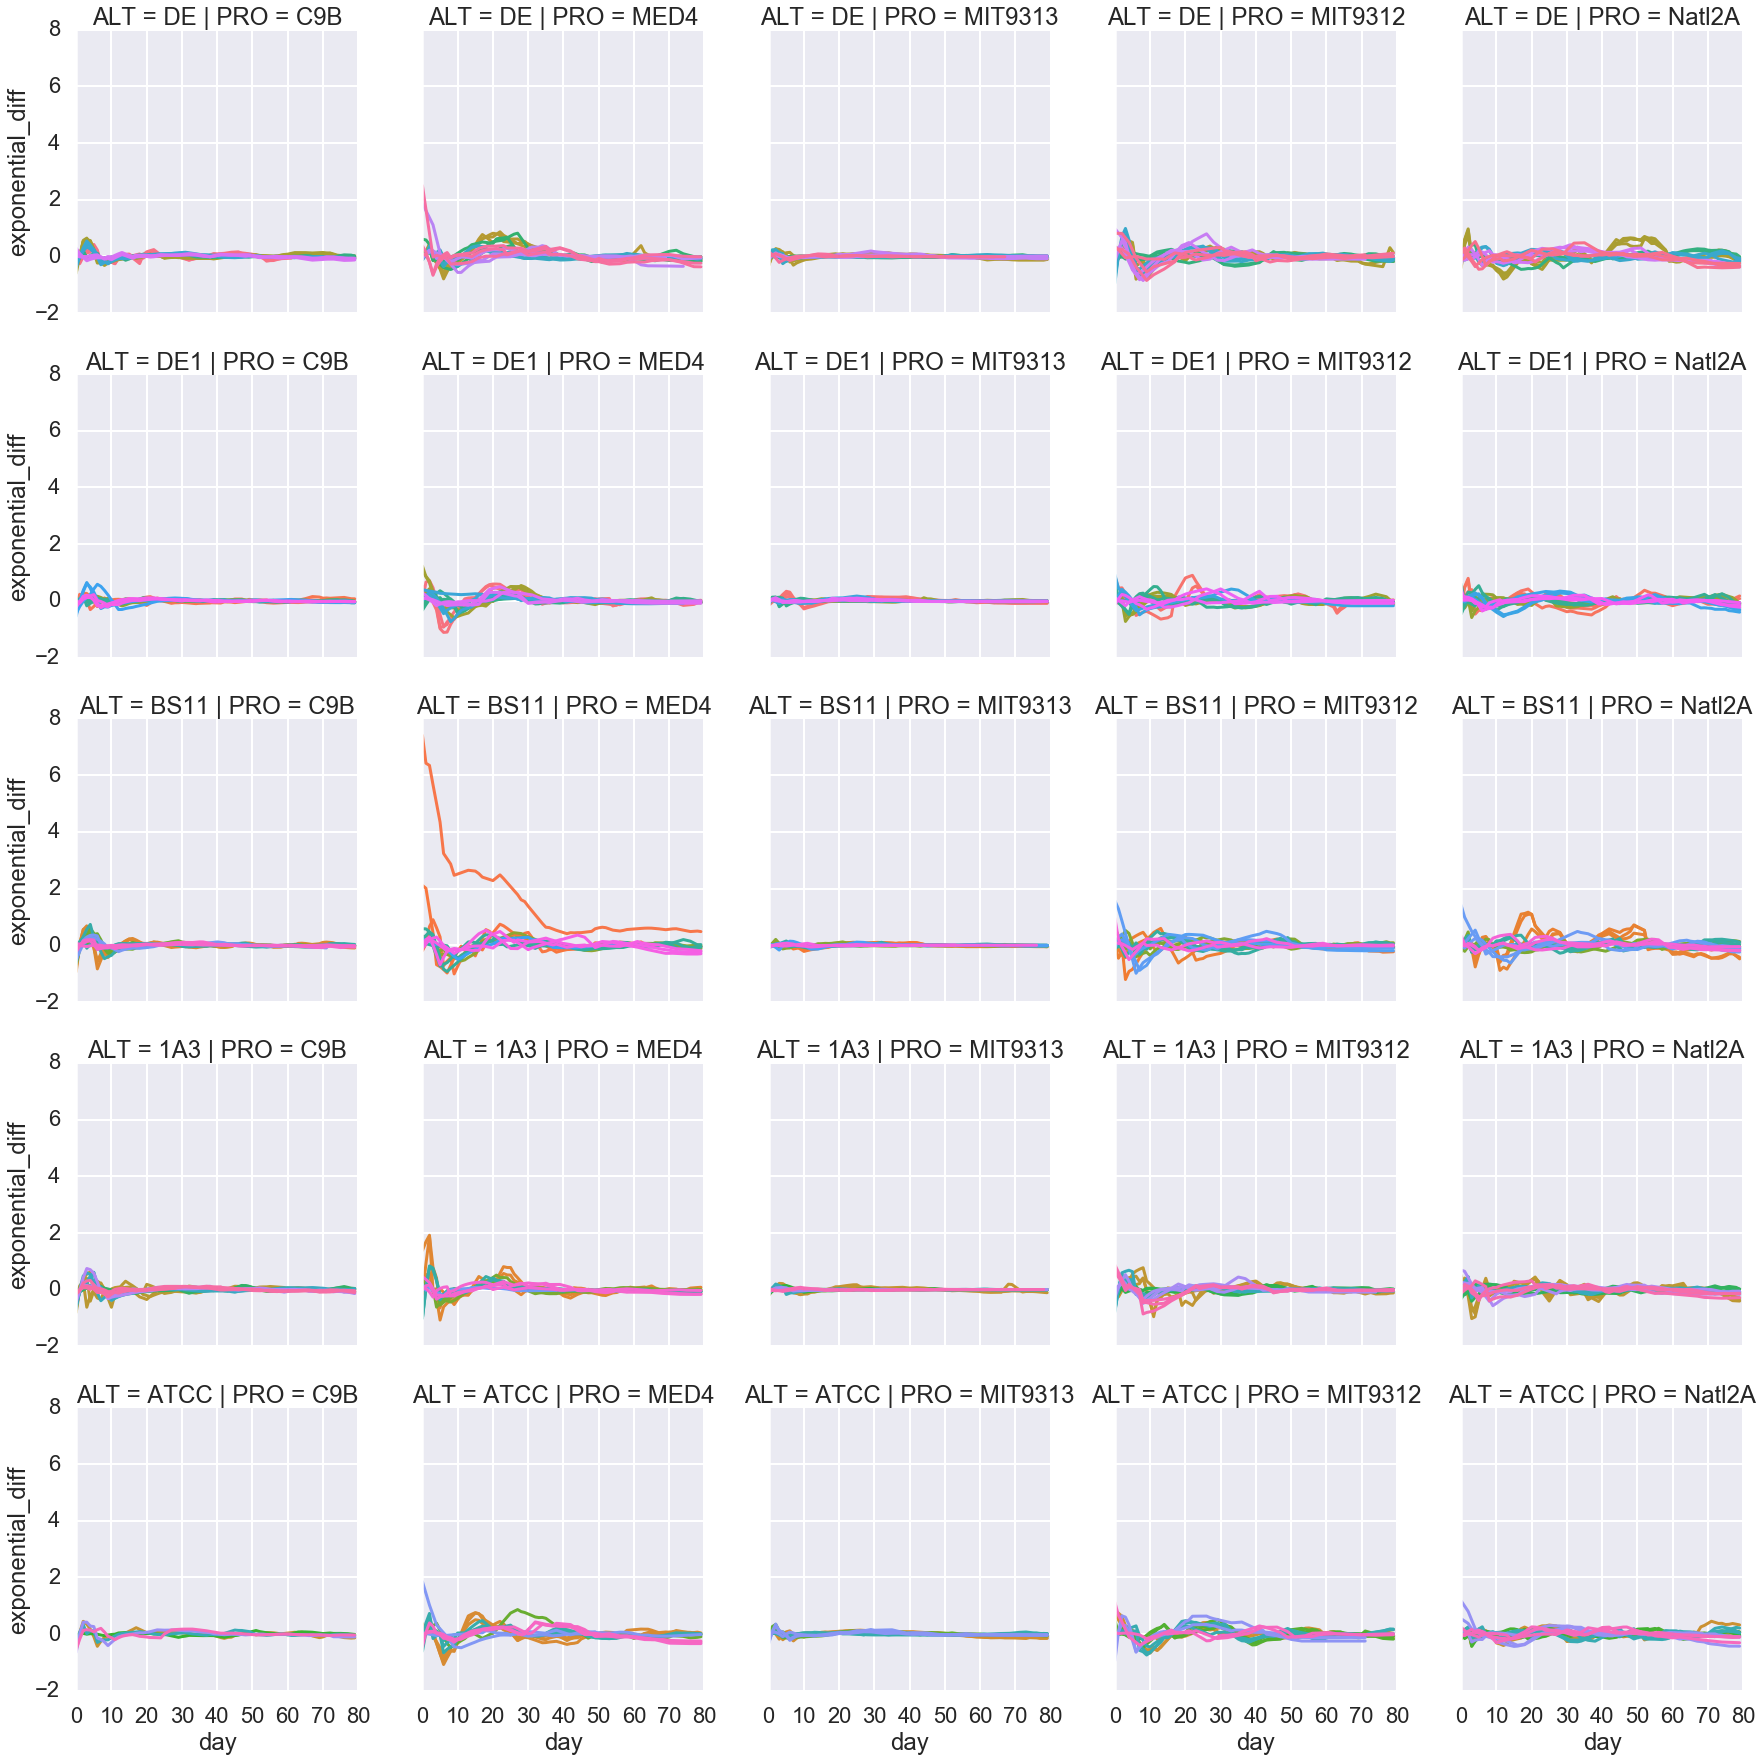

In [25]:
sns.relplot(data=dfe, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            x='day', y='exponential_diff', kind='line', hue='experiment_sample', legend=False)

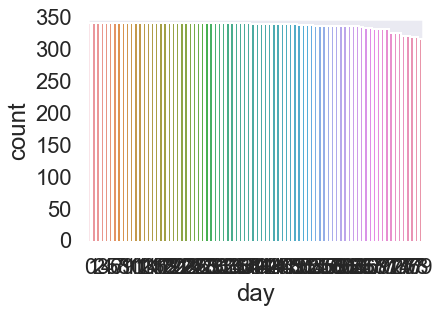

In [26]:
sns.countplot(dfe.day)

In [34]:
dfe = dfe.loc[dfe.experiment_sample != 'e1, 16A' ]

In [35]:
dfe.isna().sum()

day                  0
experiment_sample    0
experiment           0
PRO                  0
ALT                  0
sample               0
culture              0
FL                   0
exponential          0
popt_0               0
popt_1               0
popt_2               0
decline              0
exponential_diff     0
diff_norm            0
dtype: int64

In [36]:
dfe.loc[dfe.popt_2.isna()].experiment_sample.unique()

array([], dtype=object)

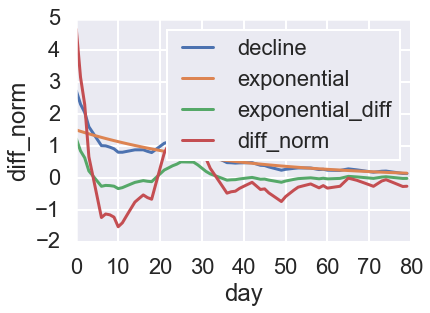

In [37]:
e = 'e3, 11C'
w = dfe.loc[dfe.experiment_sample == e]
sns.lineplot(data=w, x='day', y='decline', label='decline')
sns.lineplot(data=w, x='day', y='exponential', label='exponential')
sns.lineplot(data=w, x='day', y='exponential_diff', label='exponential_diff')
sns.lineplot(data=w, x='day', y='diff_norm', label='diff_norm')

#dfe.groupby(['experiment_sample','PRO','ALT','experiment']).day.count()

In [39]:
res, _y_list, _clf_list, _features_list = cp.compare_models(dfe, 
               value_col_list=['exponential', 'decline', 'exponential_diff', 'diff_norm', 'popt_2'], 
               resample_period_list=[None, '3d'], 
               y_col_list=['PRO','ALT', 'PRO_ALT', 'ALT_PRO'], 
               cumsummode_list=[False],
               repetitions=10,
               return_y=True)
# stats_list.extend(res)
# y_list.extend(_y_list)
# clf_list.extend(_clf_list)
# features_list.extend(_features_list)

PRO_exponential
train score 0.9202898550724637
PRO_exponential
train score 0.927536231884058
PRO_exponential
train score 0.9456521739130435
PRO_exponential
train score 0.9456521739130435
PRO_exponential
train score 0.9130434782608695
PRO_exponential
train score 0.927536231884058
PRO_exponential
train score 0.9202898550724637
PRO_exponential
train score 0.9057971014492754
PRO_exponential
train score 0.9202898550724637
PRO_exponential
train score 0.9456521739130435
ALT_exponential
train score 0.9239130434782609
ALT_exponential
train score 0.9456521739130435
ALT_exponential
train score 0.9311594202898551
ALT_exponential
train score 0.9239130434782609
ALT_exponential
train score 0.9347826086956522
ALT_exponential
train score 0.9239130434782609
ALT_exponential
train score 0.927536231884058
ALT_exponential
train score 0.9311594202898551
ALT_exponential
train score 0.9202898550724637
ALT_exponential
train score 0.927536231884058
PRO_ALT_exponential
train score 0.9166666666666666
PRO_ALT_expon

C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
ALT_PRO_decline_3d


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 0.9963768115942029
ALT_PRO_decline_3d
train score 0.9963768115942029
ALT_PRO_decline_3d
train score 1.0
PRO_exponential_diff
train score 0.9963768115942029
PRO_exponential_diff
train score 0.9963768115942029
PRO_exponential_diff
train score 1.0
PRO_exponential_diff
train score 0.9963768115942029
PRO_exponential_diff
train score 0.9927536231884058
PRO_exponential_diff
train score 0.9927536231884058
PRO_exponential_diff
train score 0.9963768115942029
PRO_exponential_diff
train score 0.9963768115942029
PRO_exponential_diff
train score 1.0
PRO_exponential_diff
train score 0.9927536231884058
ALT_exponential_diff
train score 1.0
ALT_exponential_diff
train score 0.9963768115942029
ALT_exponential_diff
train score 0.9963768115942029
ALT_exponential_diff
train score 1.0
ALT_exponential_diff
train score 0.9963768115942029
ALT_exponential_diff
train score 0.9927536231884058
ALT_exponential_diff
train score 1.0
ALT_exponential_diff
train score 0.9963768115942029
ALT_exponential_diff
tr

train score 0.6304347826086957
ALT_popt_2
train score 0.644927536231884
ALT_popt_2
train score 0.6231884057971014
ALT_popt_2
train score 0.6376811594202898
ALT_popt_2
train score 0.6485507246376812
ALT_popt_2
train score 0.6376811594202898
PRO_ALT_popt_2
train score 0.5253623188405797
PRO_ALT_popt_2
train score 0.5688405797101449
PRO_ALT_popt_2
train score 0.5471014492753623
PRO_ALT_popt_2
train score 0.5507246376811594
PRO_ALT_popt_2
train score 0.5579710144927537
PRO_ALT_popt_2
train score 0.5434782608695652
PRO_ALT_popt_2
train score 0.5471014492753623
PRO_ALT_popt_2
train score 0.5507246376811594
PRO_ALT_popt_2
train score 0.5543478260869565
PRO_ALT_popt_2
train score 0.5362318840579711
ALT_PRO_popt_2
train score 0.5398550724637681
ALT_PRO_popt_2
train score 0.5434782608695652
ALT_PRO_popt_2
train score 0.5471014492753623
ALT_PRO_popt_2
train score 0.532608695652174
ALT_PRO_popt_2
train score 0.5217391304347826
ALT_PRO_popt_2
train score 0.5398550724637681
ALT_PRO_popt_2
train scor

In [40]:
stats_df = pd.DataFrame.from_records(res)
stats_df.fillna({'resample_period' : 'N/A'}, inplace=True)

In [41]:
stats_df.describe()

accuracy_test  accuracy_train     f1_test    f1_train  n_features  \
count     400.000000      400.000000  400.000000  400.000000  400.000000   
mean        0.338808        0.912310    0.329490    0.912129   35.992500   
std         0.140798        0.131530    0.142265    0.131849   24.431428   
min         0.107692        0.590580    0.097265    0.590013    1.000000   
25%         0.230769        0.916667    0.207836    0.916541   19.000000   
50%         0.323077        0.985507    0.308437    0.985506   25.500000   
75%         0.430769        0.996377    0.420689    0.996376   62.000000   
max         0.723077        1.000000    0.722026    1.000000   80.000000   

       orig_n_features  precision_test  precision_train  recall_test  \
count       400.000000      400.000000       400.000000   400.000000   
mean         53.500000        0.364122         0.913721     0.338808   
std          26.533187        0.157066         0.129317     0.140798   
min          27.000000        0.092308         0.598085     0.107692   
25%          27.000000        0.240429         0.917251     0.230769   
50%          53.500000        0.340751         0.985769     0.323077   
75%          80.000000        0.450719         0.996438     0.430769   
max          80.000000        0.746319         1.000000     0.723077   

       recall_train  
count    400.000000  
mean       0.912310  
std        0.131530  
min        0.590580  
25%        0.916667  
50%        0.985507  
75%        0.996377  
max        1.000000

C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


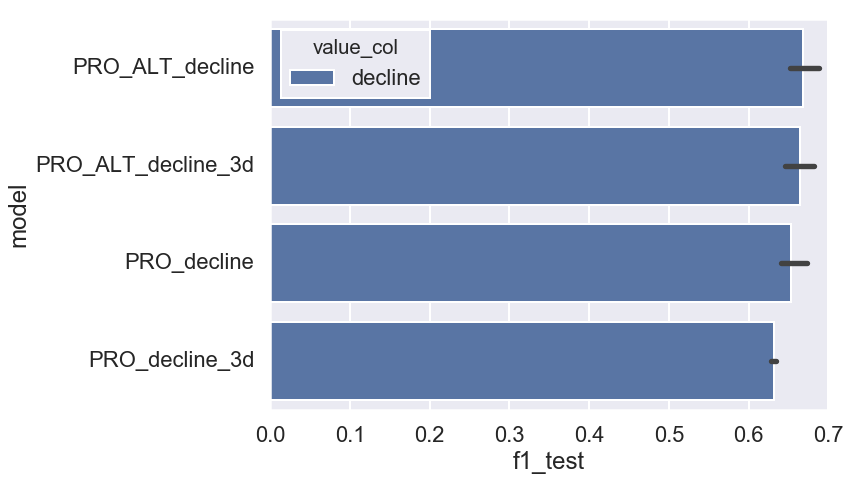

In [42]:
f, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x="f1_test", y="model", data=stats_df.sort_values(by="f1_test").nlargest(columns="f1_test", n=20),
            hue='value_col')

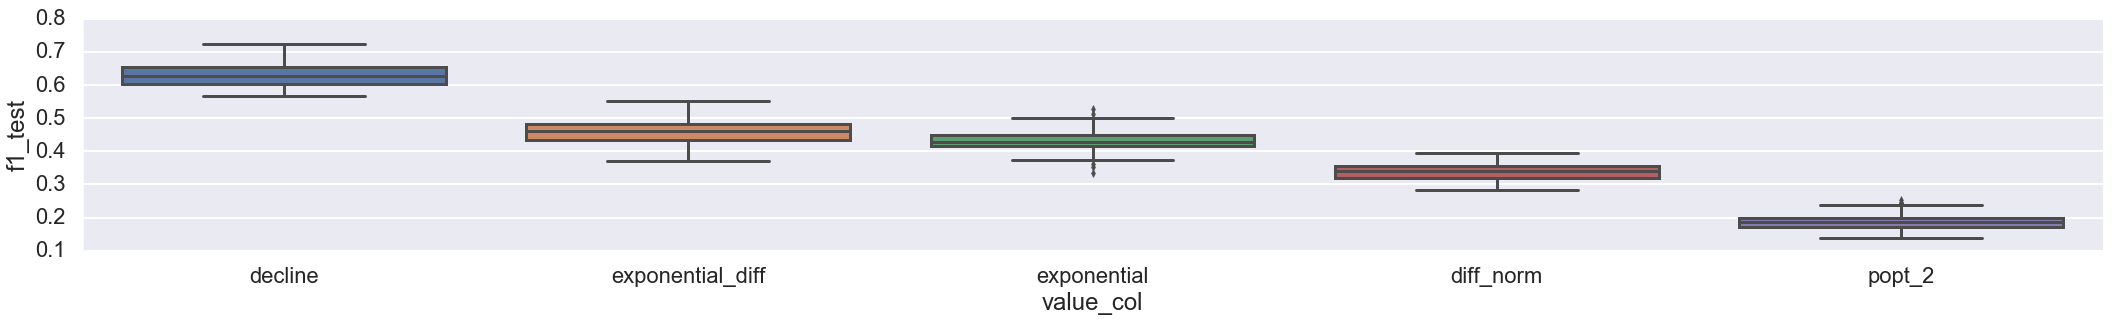

In [43]:
order = stats_df.loc[(stats_df.y_col.isin(['PRO', 'PRO_ALT'])) & (stats_df['cumsum'] == False)].groupby('value_col').f1_test.mean().sort_values(ascending=False).index
sns.catplot(data=stats_df.loc[(stats_df.y_col.isin(['PRO', 'PRO_ALT'])) & (stats_df['cumsum'] == False)], 
            x='value_col', y='f1_test', 
            #hue='resample_period', 
            #col='cumsum',
            #row='y_col', 
            aspect=6, kind='box',
            order=order,
           )

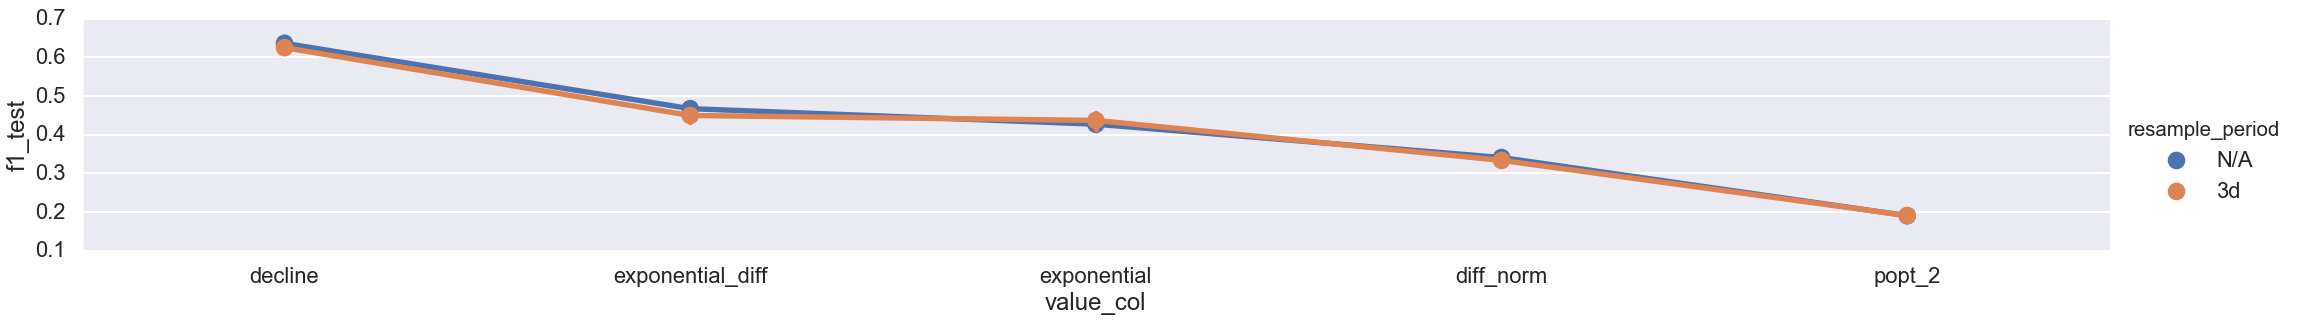

In [44]:
sns.catplot(data=stats_df.loc[stats_df.y_col.isin(['PRO', 'PRO_ALT']) & (stats_df['cumsum'] == False)], 
            x='value_col', y='f1_test', 
            hue='resample_period', 
            #col='cumsum',
            #row='y_col', 
            aspect=6, kind='point',
            order=order
           )

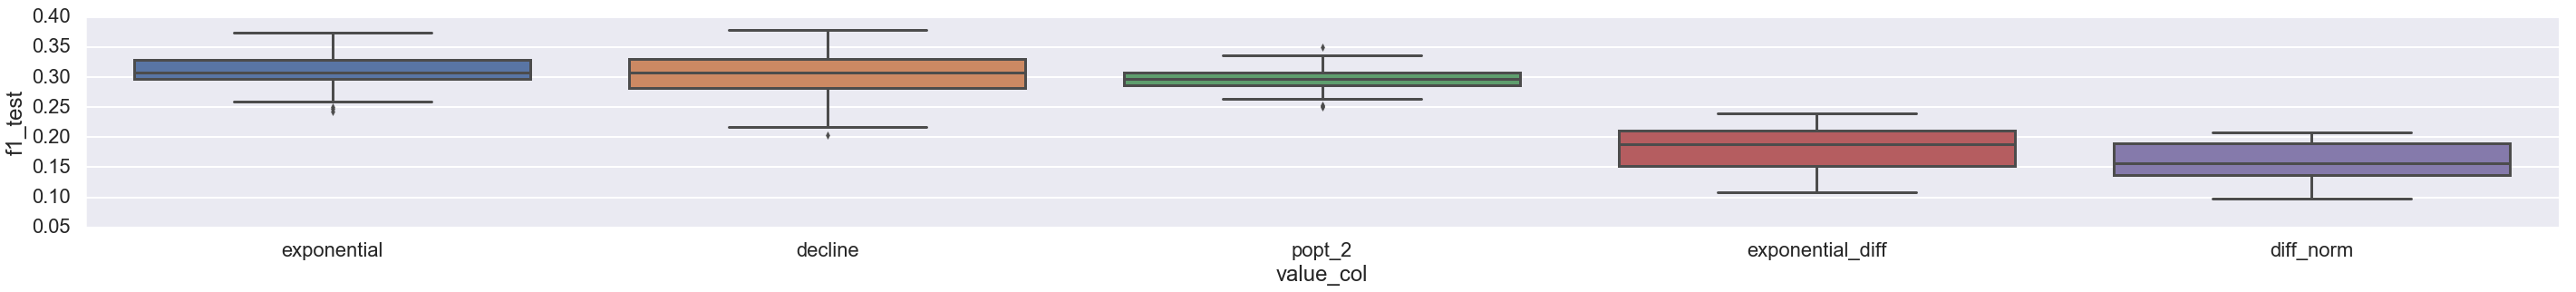

In [45]:
order = stats_df.loc[(stats_df.y_col.isin(['ALT', 'ALT_PRO'])) & (stats_df['cumsum'] == False)].groupby('value_col').f1_test.mean().sort_values(ascending=False).index
sns.catplot(data=stats_df.loc[(stats_df.y_col.isin(['ALT', 'ALT_PRO'])) & (stats_df['cumsum'] == False)], 
            x='value_col', y='f1_test', 
            #hue='resample_period', 
            #col='cumsum',
            #row='y_col', 
            aspect=8, kind='box',
            order=order,
           )

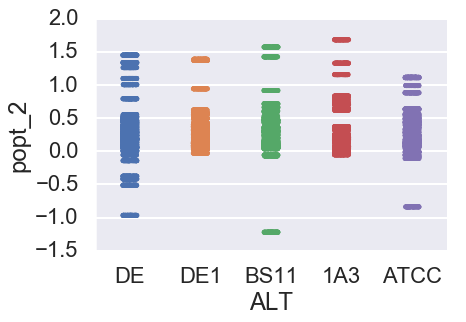

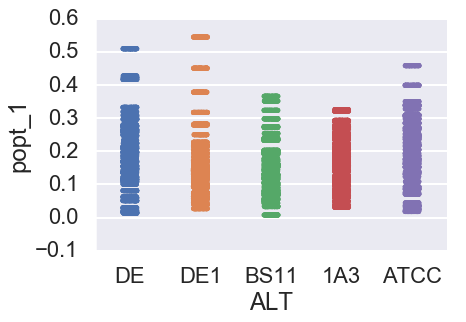

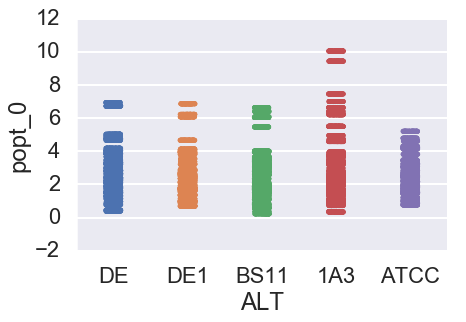

In [46]:
sns.catplot(data=dfe, x='ALT', y='popt_2', aspect=1.4)
sns.catplot(data=dfe, x='ALT', y='popt_1', aspect=1.4)
sns.catplot(data=dfe, x='ALT', y='popt_0', aspect=1.4)

In [47]:
df_exp_coef.columns[~clf.support_]

NameError: name 'df_exp_coef' is not defined

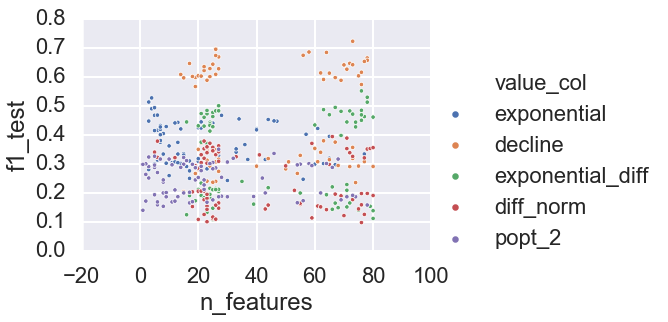

In [48]:
sns.relplot(data=stats_df, x='n_features', y='f1_test', hue='value_col', aspect=1.4)

In [49]:
stats_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       'model', 'n_features', 'orig_n_features','resample_period',
        'value_col', 'y_col']].head(10)

f1_test  accuracy_test  accuracy_train               model  n_features  \
109  0.722026       0.723077        1.000000     PRO_ALT_decline          73   
145  0.696355       0.707692        1.000000  PRO_ALT_decline_3d          26   
149  0.694348       0.692308        1.000000  PRO_ALT_decline_3d          26   
104  0.684964       0.692308        1.000000     PRO_ALT_decline          58   
105  0.683589       0.692308        0.996377     PRO_ALT_decline          64   
81   0.673614       0.676923        0.981884         PRO_decline          56   
147  0.672958       0.676923        1.000000  PRO_ALT_decline_3d          26   
144  0.668205       0.676923        0.996377  PRO_ALT_decline_3d          27   
101  0.664482       0.676923        1.000000     PRO_ALT_decline          78   
102  0.656476       0.661538        0.989130     PRO_ALT_decline          78   

     orig_n_features resample_period value_col    y_col  
109               80             N/A   decline  PRO_ALT  
145               27              3d   decline  PRO_ALT  
149               27              3d   decline  PRO_ALT  
104               80             N/A   decline  PRO_ALT  
105               80             N/A   decline  PRO_ALT  
81                80             N/A   decline      PRO  
147               27              3d   decline  PRO_ALT  
144               27              3d   decline  PRO_ALT  
101               80             N/A   decline  PRO_ALT  
102               80             N/A   decline  PRO_ALT

In [50]:
stats_df.columns

Index(['accuracy_test', 'accuracy_train', 'cumsum', 'f1_test', 'f1_train',
       'model', 'n_features', 'orig_n_features', 'precision_test',
       'precision_train', 'recall_test', 'recall_train', 'resample_period',
       'support_test', 'support_train', 'value_col', 'y_col'],
      dtype='object')

In [54]:
idx = 109
y_df =  _y_list[idx]
clf = _clf_list[idx]
features = _features_list[idx]

In [56]:
y_df.columns

Index(['PRO_ALT_decline_y', 'PRO_ALT_decline_y_PRO', 'PRO_ALT_decline_y_pred',
       'PRO_ALT_decline_y_pred_PRO', 'Type'],
      dtype='object')

accuracy: 0.7230769230769231
              precision    recall  f1-score   support

         C9B       1.00      0.85      0.92        13
        MED4       0.50      0.73      0.59        15
     MIT9312       0.62      0.38      0.48        13
     MIT9313       0.90      1.00      0.95         9
      Natl2A       0.79      0.73      0.76        15

   micro avg       0.72      0.72      0.72        65
   macro avg       0.76      0.74      0.74        65
weighted avg       0.75      0.72      0.72        65



C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


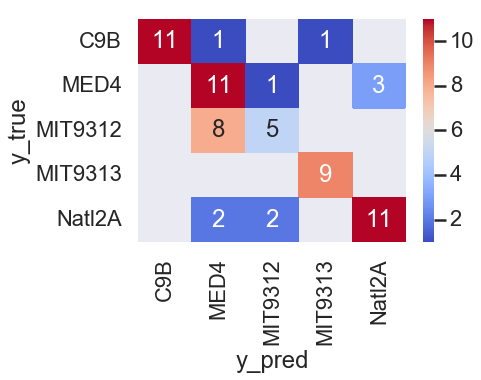

In [60]:
    from sklearn.metrics import classification_report, accuracy_score
    y_dft = y_df.loc[y_df.Type == 'Test']
    true_col = 'PRO_ALT_decline_y_PRO'
    pred_col = 'PRO_ALT_decline_y_pred_PRO'
    y_dft.rename(columns={true_col: 'y_true', pred_col: 'y_pred'}, inplace=True)
    t = y_dft.pivot_table(index='y_true', columns=['y_pred'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_dft['y_true'], y_pred=y_dft['y_pred'])}")
    print(classification_report(y_true=y_dft['y_true'], y_pred=y_dft['y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


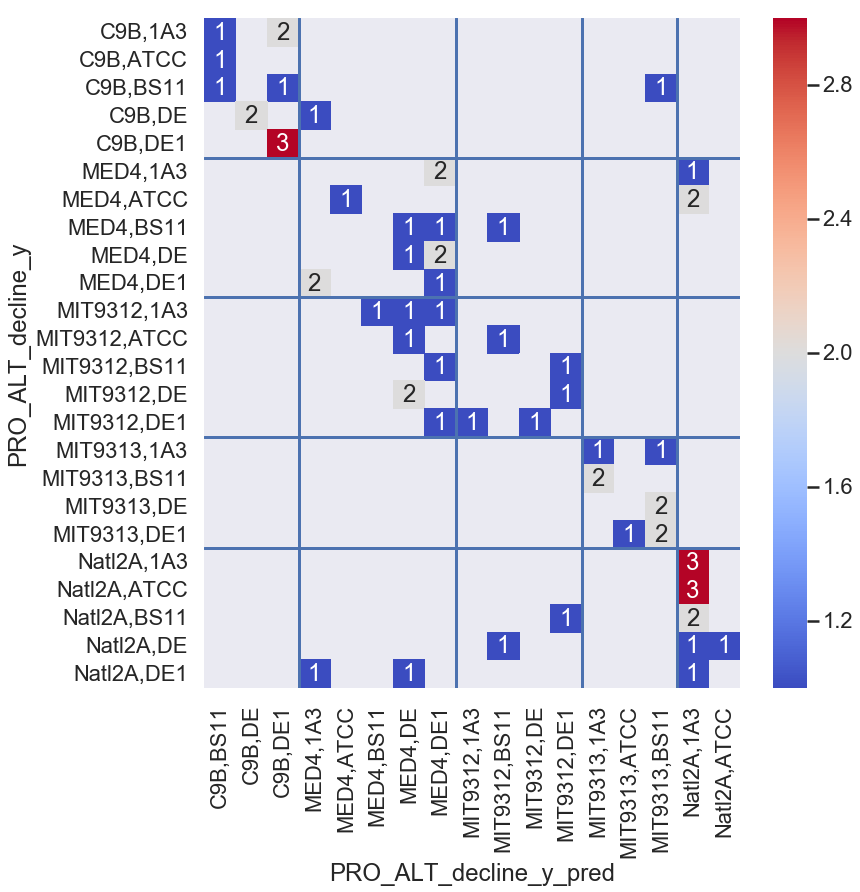

In [85]:
t = y_dft.pivot_table(index='PRO_ALT_decline_y', columns=['PRO_ALT_decline_y_pred'], 
                                              values=['Type'], aggfunc='count')
t.columns = t.columns.get_level_values(1)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(t, annot=True, cmap='coolwarm', ax=ax)
ax.axhline(5)
ax.axhline(15)
ax.axhline(19)
ax.axhline(10)
ax.axvline(3)
ax.axvline(8)
ax.axvline(12)
ax.axvline(15)


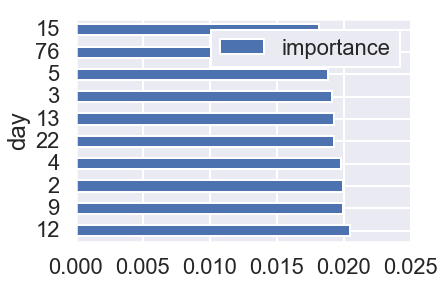

In [86]:
cp.forest_feature_importance(clf.estimator_, features[clf.support_])

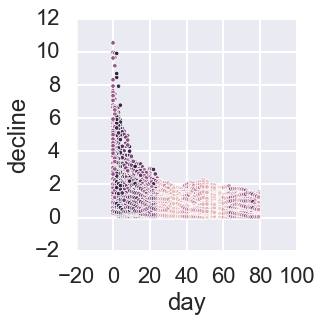

In [93]:
feature_importances = pd.DataFrame(clf.estimator_.feature_importances_,
                                   index = features[clf.support_],
                                    columns=['importance'])
mergedf = dfe.merge(feature_importances, left_on='day', right_index=True, how='left')
mergedf.head()
sns.relplot(data=mergedf, x='day', y='decline', hue='importance', legend=None)

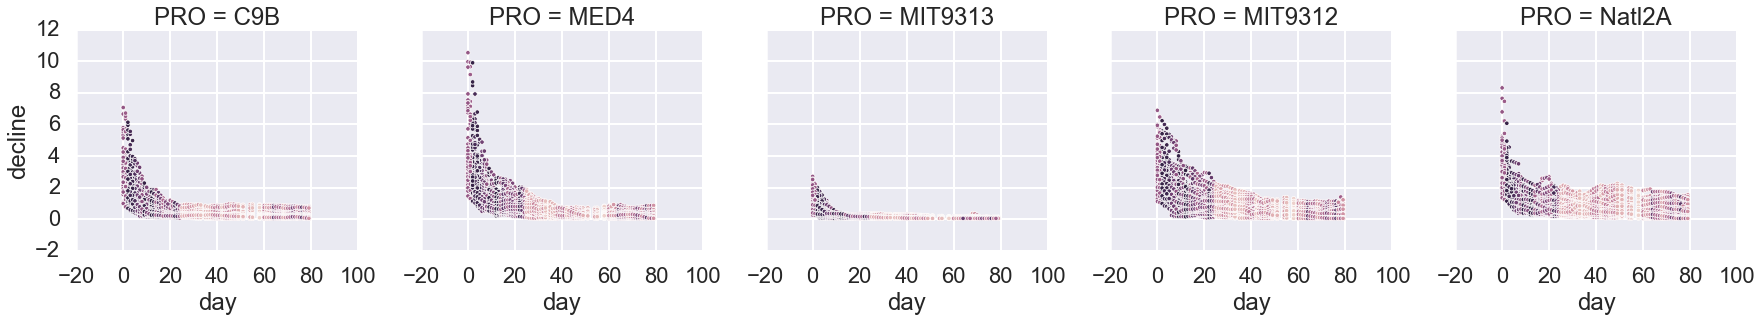

In [95]:
feature_importances = pd.DataFrame(clf.estimator_.feature_importances_,
                                   index = features[clf.support_],
                                    columns=['importance'])
mergedf = dfe.merge(feature_importances, left_on='day', right_index=True, how='left')
mergedf.head()
sns.relplot(data=mergedf, x='day', y='decline', hue='importance', legend=None, col='PRO')

# cluster by decline

In [61]:
value_col = 'decline'

In [62]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(dfe_resample3, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(dfe)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.80598064 0.10521447]


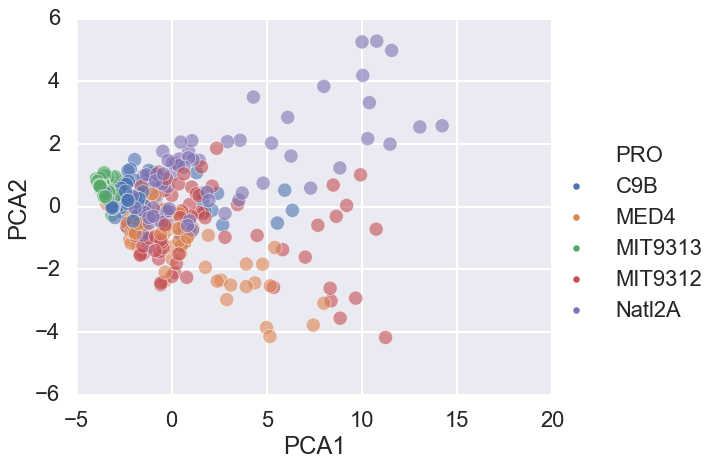

In [63]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

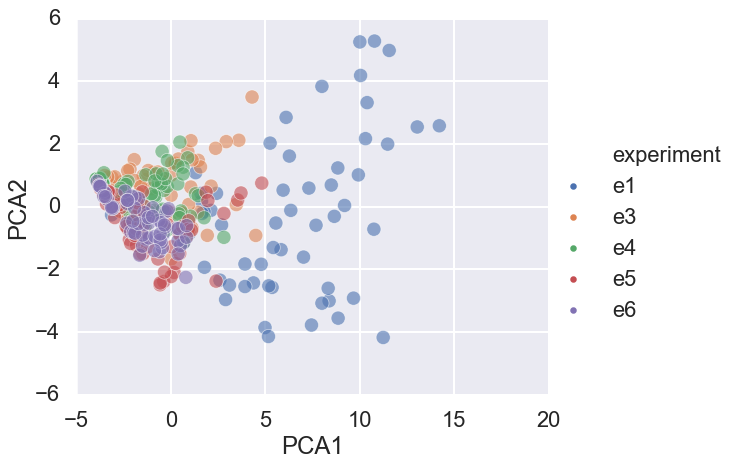

In [64]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

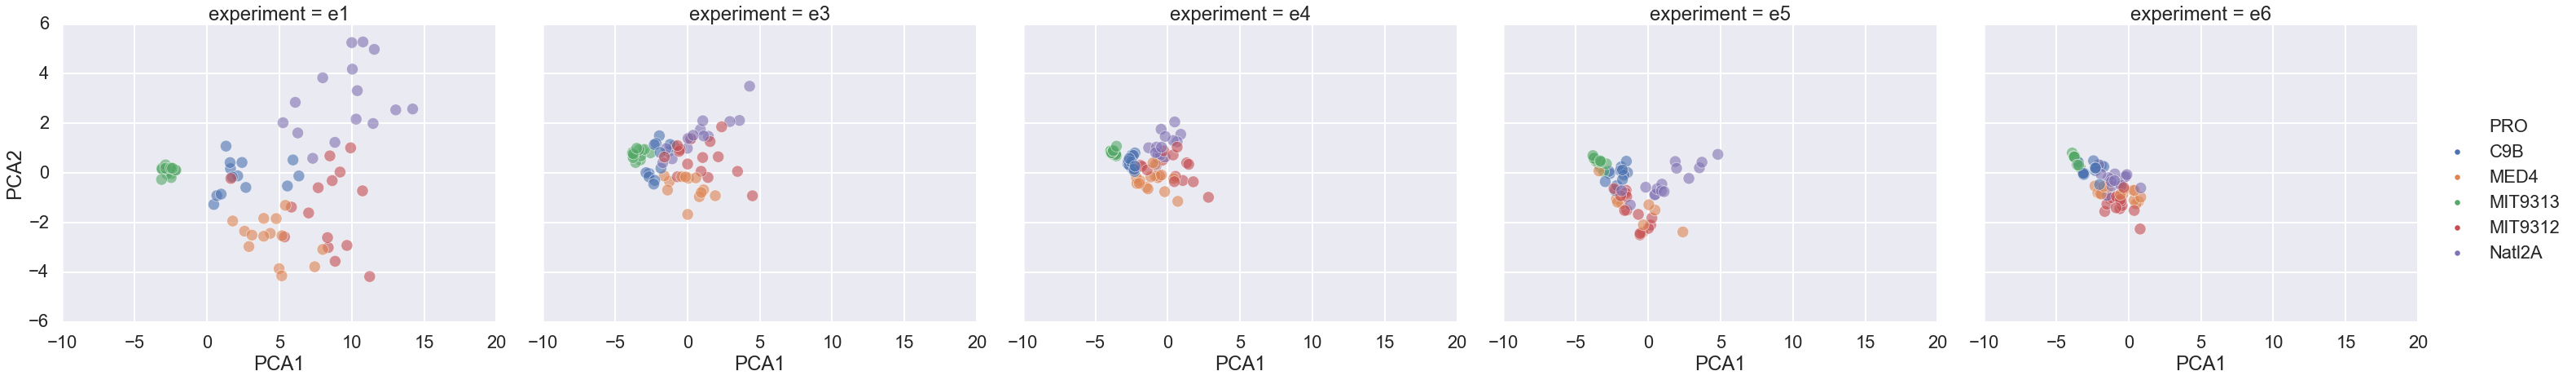

In [65]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

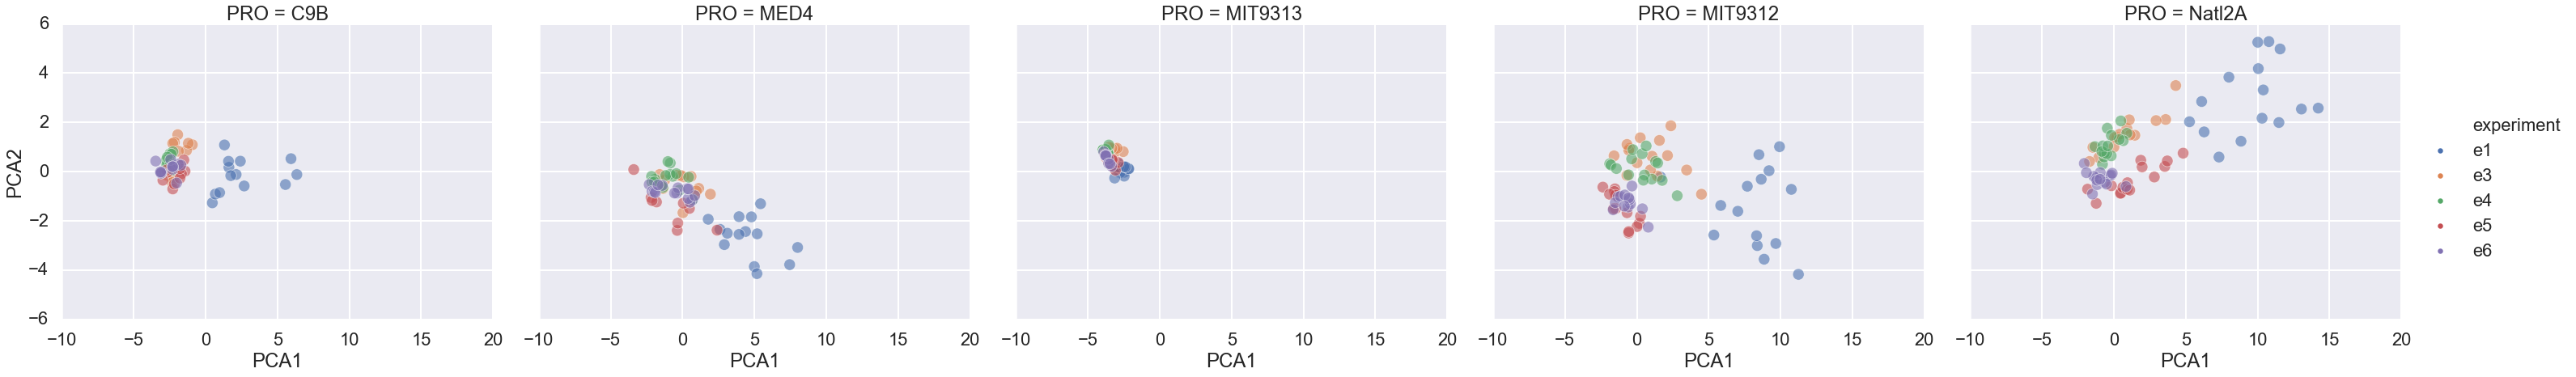

In [66]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

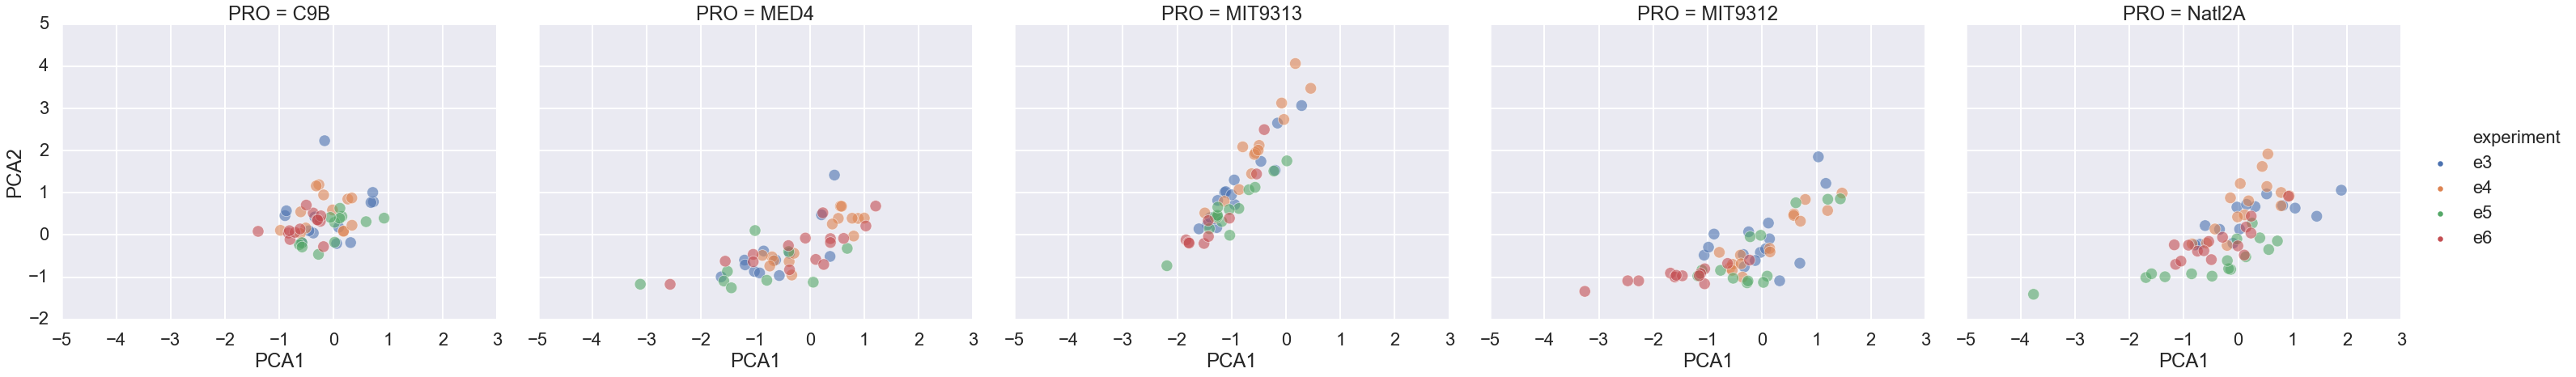

In [78]:
sns.relplot(data=dfpca.loc[dfpca['experiment'] != 'e1'], 
            x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

In [67]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'experiment'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


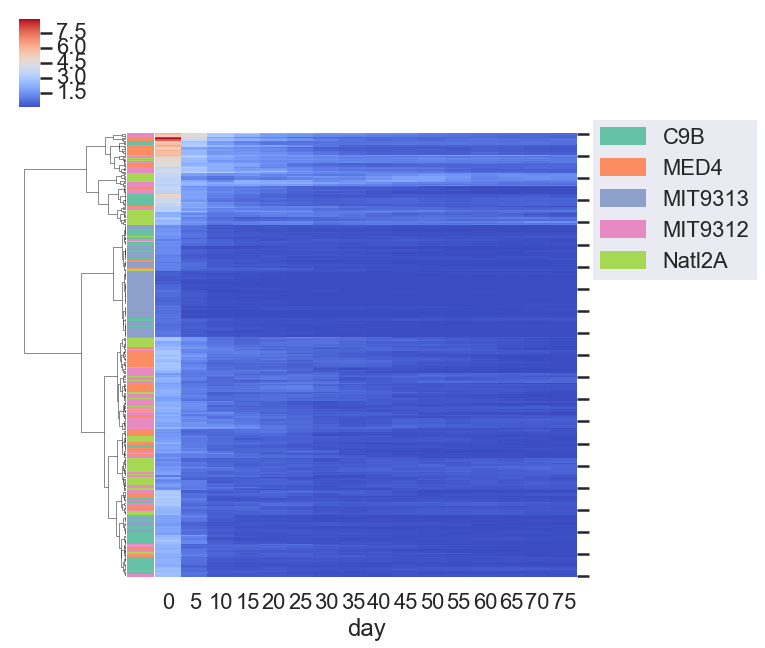

In [68]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

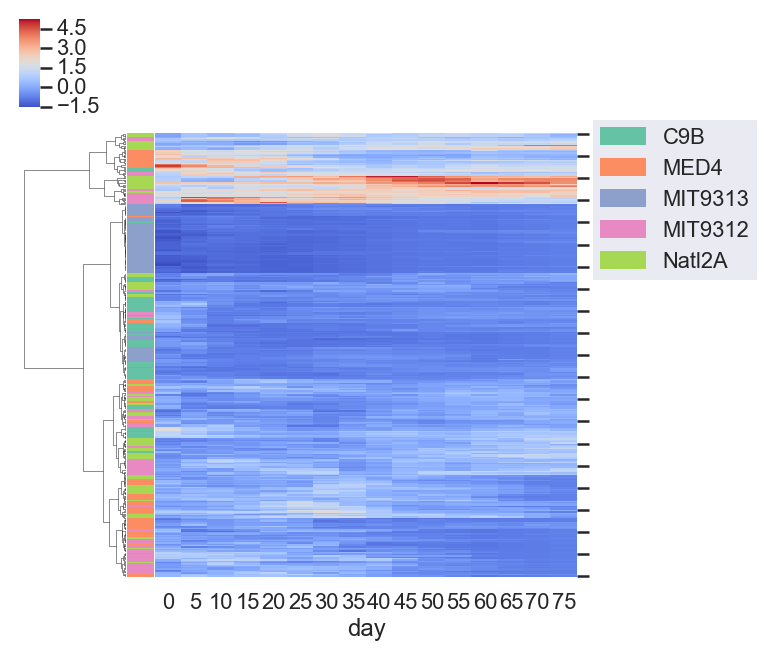

In [69]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward',
                   z_score=1
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [70]:
X.index

Index(['e1, 10A', 'e1, 10B', 'e1, 10C', 'e1, 11A', 'e1, 11B', 'e1, 11C',
       'e1, 12A', 'e1, 12B', 'e1, 12C', 'e1, 13A',
       ...
       'e6, 6B', 'e6, 6C', 'e6, 7A', 'e6, 7C', 'e6, 8A', 'e6, 8B', 'e6, 8C',
       'e6, 9A', 'e6, 9B', 'e6, 9C'],
      dtype='object', name='experiment_sample', length=341)

# cluster by exponential

In [71]:
X = dfe.groupby(['experiment_sample','popt_0', 'popt_1', 'popt_2'])['decline'].count().reset_index(level=[1,2,3])\
.drop(columns='decline')

In [72]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='3d')
#X = cp.experiments2X(dfe_resample3, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(dfe)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.51164604 0.32545436]


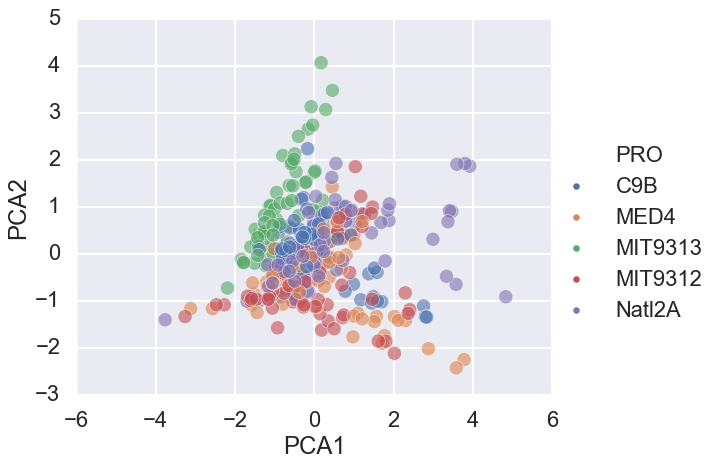

In [73]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

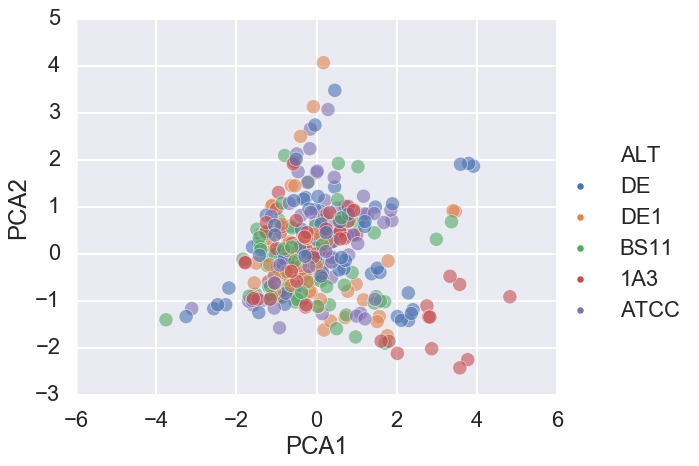

In [74]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

In [75]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'ALT'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


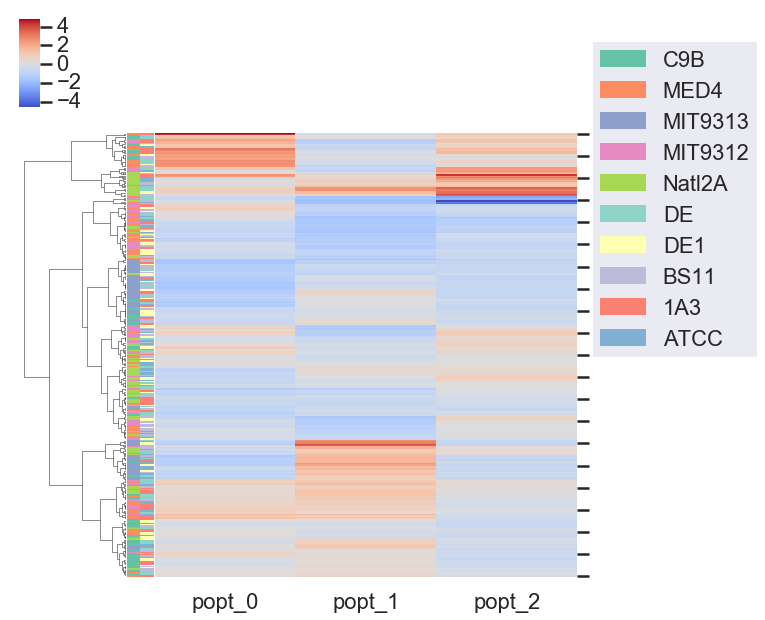

In [76]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors2
                              ], 
               method='ward',
                   z_score=1,
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [77]:
X.head()

popt_0    popt_1    popt_2
experiment_sample                              
e1, 10A            4.744960  0.191443  0.475318
e1, 10B            4.791083  0.196854  0.554282
e1, 10C            4.918696  0.209261  0.478264
e1, 11A            6.866017  0.116739  0.375157
e1, 11B            6.225501  0.140035  0.366254